In [1]:
import os
import rioxarray as rxr
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import geopandas as gpd

## Load in some Modis data from April 2020
Note: dimensions are burn_day[z,y,x] since [depth,row_num,column_num] as usual. Just confusing as x comes first - this data is put into a row vector instead of a column vector!

In [2]:
# Set the name/location of the file
file_name = "Modis data/20200401-ESACCI-L3S_FIRE-BA-MODIS-AREA_3-fv5.1-JD.tif"

# Set the start and end Julian Day 
start_JD = 92
end_JD = 122

# Open the tif file 
burn_days = rxr.open_rasterio(file_name)

# Just some usual info you can print
print("The crs of your data is:", burn_days.rio.crs)
print("The shape of your data is:", burn_days.shape)
print("The metadata for your data is:", burn_days.attrs)

The crs of your data is: EPSG:4326
The shape of your data is: (1, 25827, 35178)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0}


## Adjust the spatial limits of the data to keep only the Polesia region

In [3]:
# Define a function to return the vertices of a polygon

def extract_vertices(shape_file_path):
    """Returns a numpy array of the lat/lons corresponding to the vertices of a polygon defined by a shape file.
    
    Keyword arguments:
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    
    Prerequisites: 
    - geopandas
    - numpy
    """
    
    polygons_df = gpd.read_file(shape_file_path)
    vertices = list([list(coords) for coords in polygons_df.iloc[0]['geometry'].exterior.coords])
    return np.array(vertices)


In [4]:
# Define a function to do the cropping of the data

def crop_data_spatially(input_data, shape_file_path, zero_remap = 0):
    """Crops input data to keep only the elements within the spatial bounds defined by the input shape file.
    
    Keyword arguments:
    input_data -- DataArray of input data and corresponding x/y (latitude/longitude) coordinates
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    zero_remap -- the new value that elements outside the spatial bounds (but not dropped from the output DataArray)
                  are mapped to after the crop has occurred
                  
    Prerequisites:
    - rioxarray
    """
    
    # Check that zero_remap is the same type as the values in input_data
    try:
        if not ((isinstance(zero_remap, (int, np.integer)) and isinstance(input_data.values[0,0,0], (int, np.integer))) or
                 (isinstance(zero_remap, (float, np.float64)) and isinstance(input_data.values[0,0,0], (float, np.float64)))):
            raise TypeError('The zero_remap value provided must match the type of the input data:', type(zero_remap), type(input_data.values.dtype)) 
    
    except TypeError as error:
        print(error.args)
    
    
    # Extract the vertice's latitude/longitudes from the shape file
    vertices = extract_vertices(shape_file_path) 
    
    # Define a geometry object to define the polygon
    shape_geometry = [{'type': 'Polygon',
                       'coordinates': [vertices]}]
    
    # Crop the data using the latitude/longitudes and remap the new zero values 
    data_cropped = (input_data-zero_remap).rio.clip(shape_geometry, "epsg:4326") + zero_remap
    return data_cropped


In [5]:
# The data that is outside the polygon is automatically set to zero (due to DataArray int type being used),
# so force it to become -2 (non-burnable) by choice
burn_days_clipped = crop_data_spatially(burn_days, "Shape Files/whole_map.shp", -2)

# Rename the DataArray dimensions and print the new spatially bounded data set 
burn_days_clipped = burn_days_clipped.rename({'x': 'lon', 'y': 'lat'})
burn_days_clipped

<xarray.DataArray (band: 1, lat: 1132, lon: 4077)>
array([[[-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        ...,
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2]]], dtype=int16)
Coordinates:
  * lat          (lat) float64 53.04 53.04 53.04 53.04 ... 50.51 50.51 50.5
  * lon          (lon) float64 22.95 22.95 22.95 22.95 ... 32.09 32.09 32.1 32.1
  * band         (band) int64 1
    spatial_ref  int64 0

## Plot the fire and confidence data for April 2020

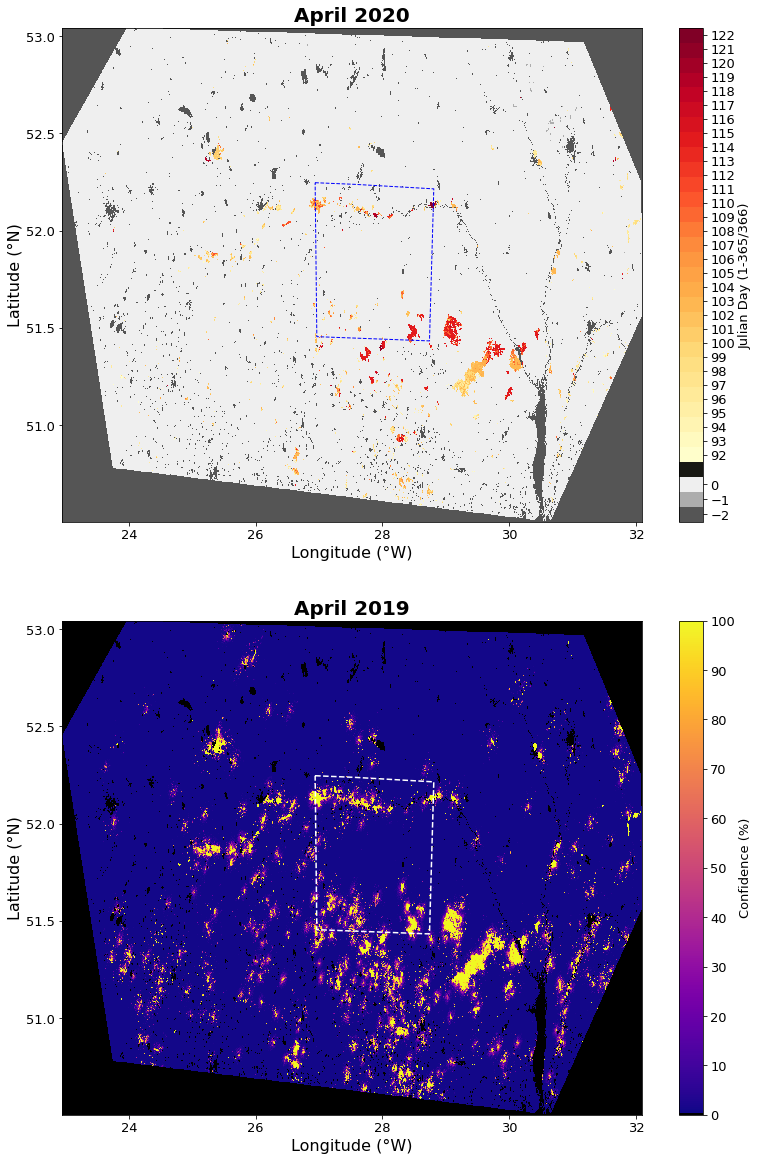

In [6]:
######## Fire Data ########

# N is the number of colours choose from spectrum (=number of days in the month being considered)
N = end_JD-start_JD

# Force the first colours in the map to be: -2 = dark grey, -1 = light grey, 0 = white and 0-start_JD = black 
# (to signify axis break if not January). Then have a scale of yellow -> orange -> red for the Julian Day of burn days 
cmaplist1 = plt.cm.gray(np.linspace(0, 1, 4))[1:]
cmaplist2 = plt.cm.YlOrRd(np.linspace(0, 1, N))

if start_JD == 1:
    # Create the new colour map for January case
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), N+2)
    
    # Define the discrete bin bounds
    bounds = np.linspace(-2.5, end_JD+0.5, N+3)
    
else:
    # Add black square for line break for non-January month
    cmaplist1 = np.vstack((cmaplist1, np.array([0,0,0,1])))
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), N+3)
    bounds = np.concatenate([np.linspace(-2.5, 0.5, 4), np.linspace(start_JD-0.5, end_JD+0.5, N)])

# Define the ticks for the colour bar
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ticks = np.concatenate([np.array([-2,-1,0]),np.arange(start_JD,end_JD+1)])

# Plot the data
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(2, figsize=(13,20))
burn_days_clipped.plot(ax=ax[0], cmap=cmap, norm=norm, cbar_kwargs={'ticks': ticks,'label': 'Julian Day (1-365/366)'});

# Finally, add a blue square to illustrate the training area
training_coords = extract_vertices("Shape Files/Project_area.shp")
ax[0].plot(training_coords[:,0],training_coords[:,1],'--b',linewidth=1);
ax[0].set_title('April 2020',fontsize=20,fontweight="bold");
ax[0].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax[0].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);


######## Confidence Data ########

# Load in the data 
file_name = "Modis data/20200401-ESACCI-L3S_FIRE-BA-MODIS-AREA_3-fv5.1-CL.tif"
conf_levels = rxr.open_rasterio(file_name)

# Limit the data to the Polesia region 
#conf_levels_clipped = conf_levels.rio.clip(geometry_polesia, "epsg:4326")
conf_levels_clipped = crop_data_spatially(conf_levels, "Shape Files/whole_map.shp")
conf_levels_clipped = conf_levels_clipped.rename({'x': 'lon', 'y': 'lat'})

# Prepare the colormap and force 0 -> black 
cmap = plt.cm.plasma
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0,0,0,1)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Plot the data 
ticks = np.arange(0,101,10)
test = conf_levels_clipped.plot(ax=ax[1], cmap=cmap,vmin=0,vmax=100,cbar_kwargs={'ticks': ticks,'label': 'Confidence (%)'});
ax[1].plot(training_coords[:,0],training_coords[:,1],'--w',linewidth=1.5);
ax[1].set_title('April 2019',fontsize=20,fontweight="bold");
ax[1].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax[1].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

## Now plot the fire and confidence data from January 2019

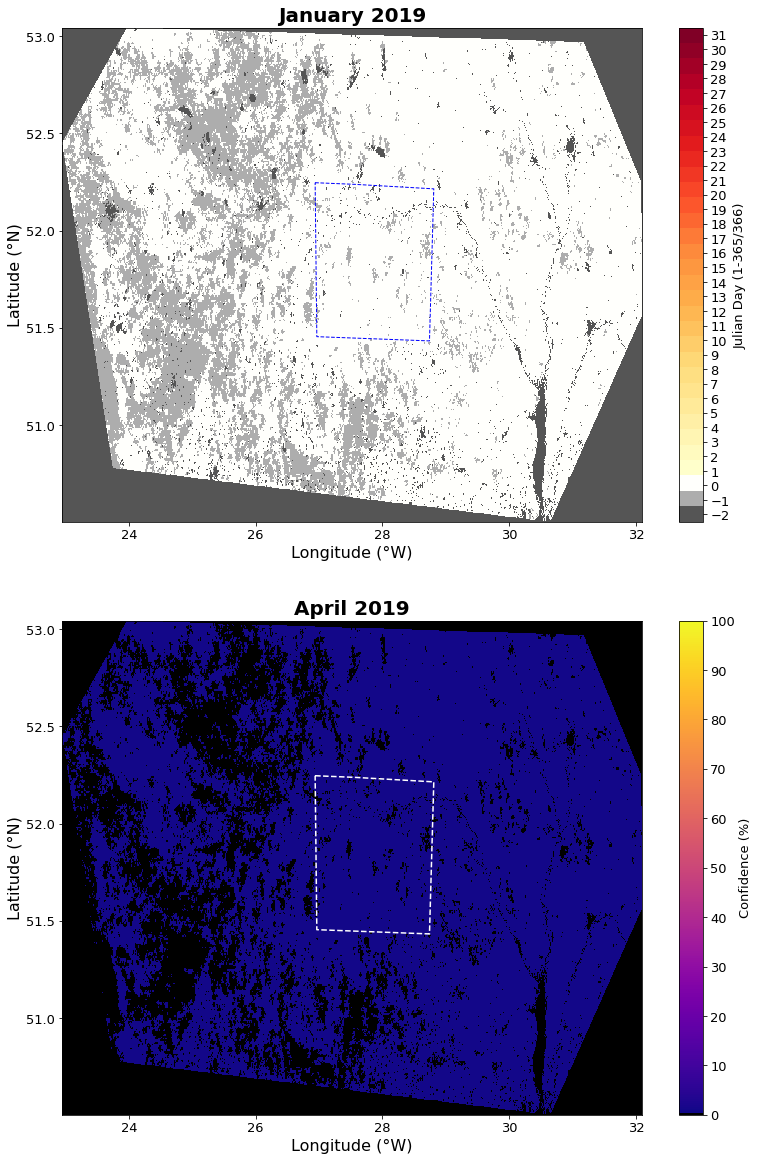

In [7]:
######## Fire Data ########

file_name = "Modis data/20190101-ESACCI-L3S_FIRE-BA-MODIS-AREA_3-fv5.1-JD.tif"
start_JD = 1
end_JD = 31
burn_days = rxr.open_rasterio(file_name)

burn_days_clipped = crop_data_spatially(burn_days, "Shape Files/whole_map.shp", -2)
burn_days_clipped = burn_days_clipped.rename({'x': 'lon', 'y': 'lat'})

N = end_JD-start_JD
cmaplist1 = plt.cm.gray(np.linspace(0, 1, 4))[1:]
cmaplist2 = plt.cm.YlOrRd(np.linspace(0, 1, N))

if start_JD == 1:
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), N+2)
    bounds = np.linspace(-2.5, end_JD+0.5, N+3)
    
else:
    cmaplist1 = np.vstack((cmaplist1, np.array([0,0,0,1])))
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), N+3)
    bounds = np.concatenate([np.linspace(-2.5, 0.5, 4), np.linspace(start_JD-0.5, end_JD+0.5, N)])
    
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ticks = np.concatenate([np.array([-2,-1,0]),np.arange(start_JD,end_JD+1)])

fig, ax = plt.subplots(2, figsize=(13,20))
burn_days_clipped.plot(ax=ax[0], cmap=cmap, norm=norm, cbar_kwargs={'ticks': ticks,'label': 'Julian Day (1-365/366)'});
ax[0].plot(training_coords[:,0],training_coords[:,1],'--b',linewidth=1);
ax[0].set_title('January 2019',fontsize=20,fontweight="bold");
ax[0].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax[0].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);


######## Confidence Data ########

file_name = "Modis data/20190101-ESACCI-L3S_FIRE-BA-MODIS-AREA_3-fv5.1-CL.tif"
conf_levels = rxr.open_rasterio(file_name)

conf_levels_clipped = crop_data_spatially(conf_levels, "Shape Files/whole_map.shp")
conf_levels_clipped = conf_levels_clipped.rename({'x': 'lon', 'y': 'lat'})

cmap = plt.cm.plasma
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0,0,0,1)
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

ticks = np.arange(0,101,10)
test = conf_levels_clipped.plot(ax=ax[1], cmap=cmap,vmin=0,vmax=100,cbar_kwargs={'ticks': ticks,'label': 'Confidence (%)'});
ax[1].plot(training_coords[:,0],training_coords[:,1],'--w',linewidth=1.5);
ax[1].set_title('April 2019',fontsize=20,fontweight="bold");
ax[1].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax[1].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);
